In [4]:
import numpy as np

In [2]:
import os

# Directory containing the npz files
directory = '/share/project_data/dump_match_data' # Where npz files

# List all files in the directory
files = os.listdir(directory)

# Filter out the npz files
npz_files = [file for file in files if file.endswith('.npz')]

# Sort the files to get the first one
npz_files.sort()

In [42]:
import cv2
import pandas as pd

# Iterate over all npz files
# Initialize lists to store the results
samples = []
fundamental_matrices = []

# Iterate over all npz files
for npz_file in npz_files:
    # Load the npz file
    data = np.load(os.path.join(directory, npz_file))

    # Extract matches and keypoints
    matches = data['matches']
    kpts0 = data['keypoints0']
    kpts1 = data['keypoints1']
    match_conf = data['match_confidence']
    
    # Filter valid matches
    valid = []
    cnt = 0
    bad = 0
    mkpts0 = []
    mkpts1 = []
    for i in range(len(matches)):
        #print(match_conf[i])
        is_valid = matches[i] > -1 and match_conf[i] >= 0.1
        if is_valid:
            cnt += 1
            #print(f"Match: {matches[i]}, Conf: { match_conf[i]}")
            mkpts0.append(kpts0[i])
            mkpts1.append(kpts1[matches[i]])
    
    #valid = matches > -1
    #mkpts0 = kpts0[valid]
    #mkpts1 = kpts1[matches[valid]]
    try:
    # Estimate the fundamental matrix using the matched keypoints
        F, mask = cv2.findFundamentalMat(np.array(mkpts0), np.array(mkpts1), cv2.FM_RANSAC)
    except Exception as e:
        print(mkpts0)
        print(mkpts1)
        print(cnt)
        print(npz_file)
        F = None
    
    # Extract scene name and image names
    scene_name = data['scene_name']
    image_name0 = npz_file.split('-')[0]
    image_name1 = npz_file.split('-')[1]
    
    
    # Append the results to the lists
    samples.append(f"{scene_name};{image_name0}-{image_name1}")
    
    if F is not None:
        if F.shape != (3,3):
            print(F.shape)
        F = F.reshape(-1)
        F = F[:9]
    fundamental_matrices.append(F)

# Create a dataframe with the collected data
df = pd.DataFrame({
    'sample_id': samples,
    'fundamental_matrix': fundamental_matrices
})


missing = df.sample_id[df.fundamental_matrix.isna()]
missing_df = pd.DataFrame(missing, columns=['sample_id'])
missing_df['fundamental_matrix'] = missing_df.apply(lambda row: np.random.rand(9), axis=1)
final = pd.concat([df, missing_df]).reset_index(drop=True)[['sample_id', 'fundamental_matrix']]

final = final.dropna()
final['fundamental_matrix'] = final['fundamental_matrix'].apply(lambda x: ' '.join(f'{num:.5e}' for num in x))
print(final)
final.to_csv("/share/project_data/submit_result_fixes.csv", index=False)

[]
[]
0
30992601_6981174639-06875168_2586568374-matches.npz
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
(9, 3)
[]
[]
0
95177872_8272975292-56383511_4575849881-matches.npz
(9, 3)
(9, 3)
(9, 3)
[]
[]
0
95357069_10894925523-02101941_5110091706-matches.npz
[]
[]
0
95357069_10894925523-11517869_8080585975-matches.npz
[]
[]
0
95357069_10894925523-16926208_509236966-matches.npz
[]
[]
0
95357069_10894925523-17657592_4442000848-matches.npz
[]
[]
0
95357069_10894925523-25162462_2661987573-matches.npz
(9, 3)
[]
[]
0
95357069_10894925523-52811327_882920066-matches.npz
[]
[]
0
95357069_10894925523-54336631_13023393373-matches.npz
[]
[]
0
95357069_10894925523-54526944_533081478-matches.npz
[]
[]
0
95357069_10894925523-64705685_712918691-matches.npz
[]
[]
0
95357069_10894925523-66842228_181918175-matches.npz
[]
[]
0
95357069_10894925523-67532550_2059075766-matches.npz
(9, 3)
(9, 3)
(9, 3)
(9, 3)
[]
[]
0
97270767_81833198-95357069_10894925523-matches.npz


09557933_8986854186-06248142_11139526066-matches.npz


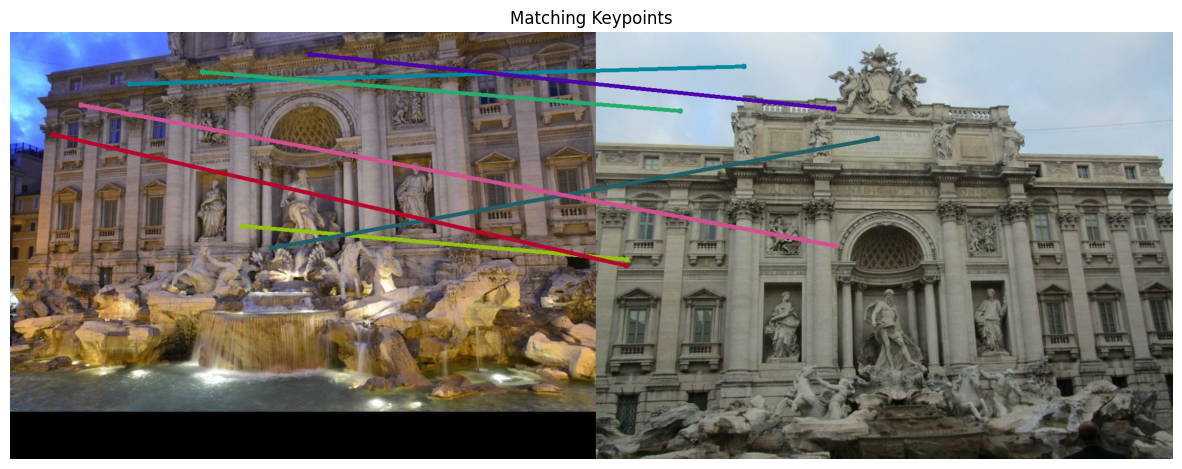

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def draw_matches(image0_path, image1_path, kpts0, kpts1, matches, match_conf):
    """
    Draws matches between two images based on keypoints and matches.

    Args:
        image0_path (str): Path to the first image.
        image1_path (str): Path to the second image.
        kpts0 (ndarray): Keypoints in the first image (Nx2 array).
        kpts1 (ndarray): Keypoints in the second image (Mx2 array).
        matches (ndarray): Indices of matches as pairs of (kpts0 index, kpts1 index) (1D array).
        match_conf (ndarray): Confidence scores for the matches (1D array).
    """
    # Ensure keypoints and matches are numpy arrays
    kpts0 = np.array(kpts0)
    kpts1 = np.array(kpts1)
    matches = np.array(matches)
    match_conf = np.array(match_conf)

    # Load images
    img0 = cv2.imread(image0_path, cv2.IMREAD_COLOR)
    img1 = cv2.imread(image1_path, cv2.IMREAD_COLOR)
    if img0 is None or img1 is None:
        raise FileNotFoundError("One or both image paths are invalid.")

    # Filter matches based on confidence threshold
    confidence_threshold = 0.8
    valid_indices = np.where(match_conf > confidence_threshold)[0]
    valid_matches = matches[valid_indices]  # Filter matches
    valid_confidences = match_conf[valid_indices]  # Filter corresponding confidences

    # Extract corresponding keypoints for valid matches
    points0 = kpts0[valid_indices]  # Keypoints from the first image
    points1 = kpts1[valid_matches]  # Keypoints from the second image

    # Create a canvas to display images side by side
    h0, w0 = img0.shape[:2]
    h1, w1 = img1.shape[:2]
    canvas = np.zeros((max(h0, h1), w0 + w1, 3), dtype=np.uint8)
    canvas[:h0, :w0, :] = img0
    canvas[:h1, w0:w0 + w1, :] = img1

    # Draw matches
    cnt = 0
    for pt0, pt1, conf in zip(points0, points1, valid_confidences):
        pt0 = tuple(map(int, pt0))  # Keypoint in the first image
        pt1 = tuple(map(int, pt1 + np.array([w0, 0])))  # Offset for the second image
        color = tuple(np.random.randint(0, 255, 3).tolist())
        thickness = 1 + int(conf * 5)  # Line thickness based on confidence
        cv2.line(canvas, pt0, pt1, color, thickness)
        cv2.circle(canvas, pt0, 5, color, -1)
        cv2.circle(canvas, pt1, 5, color, -1)
        cnt += 1
        if cnt > 6:
            break

    # Display the result
    plt.figure(figsize=(15, 10))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title("Matching Keypoints")
    plt.show()

    
# Example usage
# Replace with your actual paths and data
p = npz_files[200]
print(p)
data = np.load(os.path.join(directory, p))
matches = data['matches']
kpts0 = data['keypoints0']
kpts1 = data['keypoints1']
match_conf = data['match_confidence']

image0_path = "/share/project_data/test_images/trevi_fountain/09557933_8986854186.jpg"
image1_path = "/share/project_data/test_images/trevi_fountain/06248142_11139526066.jpg"
draw_matches(image0_path, image1_path, kpts0, kpts1, matches, match_conf)


In [59]:
data = np.load(os.path.join(directory, p))
matches = data['matches']
kpts0 = data['keypoints0']
kpts1 = data['keypoints1']
match_conf = data['match_confidence']

print(len(kpts1))

863


In [23]:
final['fundamental_matrix'] = final['fundamental_matrix'].apply(lambda x: ' '.join(f'{float(num):.5e}' for num in x))
final.to_csv("/share/project_data/submit_result.csv")

ValueError: could not convert string to float: '.'

In [25]:
final

,sample_id,fundamental_matrix
0,st_pauls_cathedral;00593112_5162872967-0016289...,"[4.022137449114088e-06, 0.00013235015925524445..."
1,st_pauls_cathedral;01024897_4276850874-0016289...,"[-9.15283027218411e-05, 0.0028072223183918644,..."
2,st_pauls_cathedral;01024897_4276850874-0059311...,"[8.531207367734791e-07, 5.6906908173883015e-06..."
3,st_peters_square;01086691_5427945640-00077205_...,"[3.167129569414257e-07, -4.090114942119587e-05..."
4,st_pauls_cathedral;01207461_5308976270-0016289...,"[-2.742166472973638e-07, -1.7157864994022375e-..."
...,...,...
18998,notre_dame_front_facade;97270767_81833198-9535...,"[0.8549730219590014, 0.21424814344873333, 0.85..."
18999,notre_dame_front_facade;99959942_5064636197-13...,"[0.44097013068616153, 0.2418335885395042, 0.10..."
19000,notre_dame_front_facade;99959942_5064636197-30...,"[0.380433774869682, 0.4978282328345378, 0.7375..."
19001,notre_dame_front_facade;99959942_5064636197-86...,"[0.4092375443788512, 0.2065848139773031, 0.292..."
